# Objective: fine-tuning DETR
-   Official DETR repository: https://github.com/facebookresearch/detr

## Define useful boilerplate functions

Adapted from:
-   https://colab.research.google.com/github/facebookresearch/detr/blob/colab/notebooks/detr_attention.ipynb

In [1]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

torch.set_grad_enabled(False);

2.0.1+cu118 True


In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [3]:
import torchvision.transforms as T

# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [4]:
def filter_bboxes_from_outputs(outputs,
                               threshold=0.7):

  # keep only predictions with confidence above threshold
  probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > threshold

  probas_to_keep = probas[keep]

  # convert boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

  return probas_to_keep, bboxes_scaled

In [5]:
# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [6]:
import matplotlib.pyplot as plt

def plot_results(pil_img, prob=None, boxes=None):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    if prob is not None and boxes is not None:
      for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
          ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=c, linewidth=3))
          cl = p.argmax()
          text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
          ax.text(xmin, ymin, text, fontsize=15,
                  bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

## Load pre-trained weights

Load a check-point (urls can be found [here](https://github.com/facebookresearch/detr#model-zoo)), then remove the classification head.

In [7]:
# Get pretrained weights
checkpoint = torch.hub.load_state_dict_from_url(
            url='https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth',
            map_location='cpu',
            check_hash=True)

# Remove class weights
del checkpoint["model"]["class_embed.weight"]
del checkpoint["model"]["class_embed.bias"]

# Save
torch.save(checkpoint,
           'detr/detr-r50_no-class-head.pth')

In [8]:
%matplotlib inline
import pycocotools.coco as coco
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

## Load an image for a demo

In [9]:
dataDir='data/custom/'
dataType='train2017'
annFile='{}annotations/custom_train.json'.format(dataDir)

In [10]:
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


In [11]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())

nms=[cat['name'] for cat in cats]
print('Categories: {}'.format(nms))

nms = set([cat['supercategory'] for cat in cats])
print('Super-categories: {}'.format(nms))

Categories: ['surface structure', 'pole']
Super-categories: {''}


In [12]:
# load and display image
catIds = coco.getCatIds(catNms=['surface structure']);
imgIds = coco.getImgIds(catIds=catIds );

Image n°827
Image name: data/custom//train2017/structure5_11.jpg


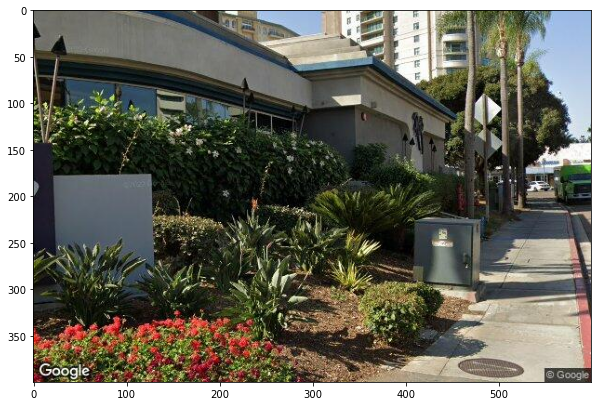

In [13]:
img_id = imgIds[np.random.randint(0,len(imgIds))]
print('Image n°{}'.format(img_id))

img = coco.loadImgs(img_id)[0]

img_name = '%s/%s/%s'%(dataDir, dataType, img['file_name'])
print('Image name: {}'.format(img_name))

I = io.imread(img_name)
plt.figure()
plt.imshow(I)

In [14]:
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds)
anns = coco.loadAnns(annIds)

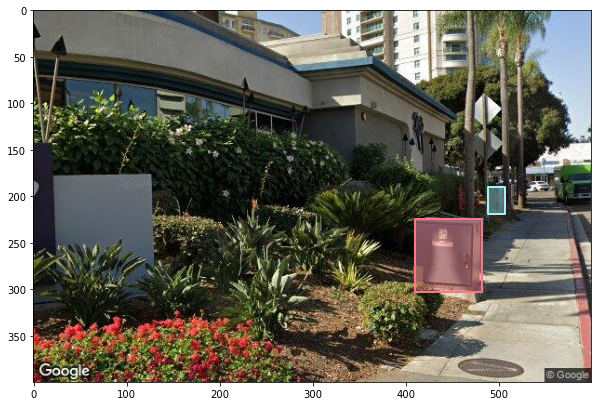

In [15]:
plt.imshow(I)
coco.showAnns(anns, draw_bbox=True)

## Fine-tuning

In [16]:
first_class_index = 0

assert(first_class_index in [0, 1])

if first_class_index == 0:

  # There is one class, balloon, with ID n°0.

  num_classes = 2

  finetuned_classes = [
      'surface structure',
      'pole'
  ]

  # The `no_object` class will be automatically reserved by DETR with ID equal
  # to `num_classes`, so ID n°1 here.

else:

  # There is one class, balloon, with ID n°1.
  #
  # However, DETR assumes that indexing starts with 0, as in computer science,
  # so there is a dummy class with ID n°0.
  # Caveat: this dummy class is not the `no_object` class reserved by DETR.

  num_classes = 2

  finetuned_classes = [
      'N/A', 'balloon',
  ]

  # The `no_object` class will be automatically reserved by DETR with ID equal
  # to `num_classes`, so ID n°2 here.

print('First class index: {}'.format(first_class_index))
print('Parameter num_classes: {}'.format(num_classes))
print('Fine-tuned classes: {}'.format(finetuned_classes))

First class index: 0
Parameter num_classes: 2
Fine-tuned classes: ['surface structure', 'pole']


## Main Script to train model

In [17]:
!python detr/main.py \
  --dataset_file "custom" \
  --coco_path "data/custom/" \
  --output_dir "outputs" \
  --resume "detr/detr-r50_no-class-head.pth" \
  --num_classes $num_classes \
  --epochs 10 \
  --device cuda \
  #--resume "outputs/checkpoint.pth"

Not using distributed mode
git:
  sha: e891373a8cab93d3719afb0acff28de94c6dc6a3, status: clean, branch: finetune

Namespace(lr=0.0001, lr_backbone=1e-05, batch_size=2, weight_decay=0.0001, epochs=10, lr_drop=200, clip_max_norm=0.1, frozen_weights=None, backbone='resnet50', dilation=False, position_embedding='sine', enc_layers=6, dec_layers=6, dim_feedforward=2048, hidden_dim=256, dropout=0.1, nheads=8, num_queries=100, pre_norm=False, masks=False, aux_loss=True, set_cost_class=1, set_cost_bbox=5, set_cost_giou=2, mask_loss_coef=1, dice_loss_coef=1, bbox_loss_coef=5, giou_loss_coef=2, eos_coef=0.1, num_classes=2, dataset_file='custom', coco_path='data/custom/', coco_panoptic_path=None, remove_difficult=False, output_dir='outputs', device='cuda', seed=42, resume='outputs/checkpoint.pth', start_epoch=0, eval=False, num_workers=2, world_size=1, dist_url='env://', distributed=False)
/opt/conda/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrain

## Metrics Evaluation

In [18]:
"""
Plotting utilities to visualize training logs.
"""
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path, PurePath


def plot_logs(logs, fields=('class_error', 'loss_bbox_unscaled', 'mAP'), ewm_col=0, log_name='log.txt'):
    '''
    Function to plot specific fields from training log(s). Plots both training and test results.

    :: Inputs - logs = list containing Path objects, each pointing to individual dir with a log file
              - fields = which results to plot from each log file - plots both training and test for each field.
              - ewm_col = optional, which column to use as the exponential weighted smoothing of the plots
              - log_name = optional, name of log file if different than default 'log.txt'.

    :: Outputs - matplotlib plots of results in fields, color coded for each log file.
               - solid lines are training results, dashed lines are test results.

    '''
    func_name = "plot_utils.py::plot_logs"

    # verify logs is a list of Paths (list[Paths]) or single Pathlib object Path,
    # convert single Path to list to avoid 'not iterable' error

    if not isinstance(logs, list):
        if isinstance(logs, PurePath):
            logs = [logs]
            print(f"{func_name} info: logs param expects a list argument, converted to list[Path].")
        else:
            raise ValueError(f"{func_name} - invalid argument for logs parameter.\n \
            Expect list[Path] or single Path obj, received {type(logs)}")

    # Quality checks - verify valid dir(s), that every item in list is Path object, and that log_name exists in each dir
    for i, dir in enumerate(logs):
        if not isinstance(dir, PurePath):
            raise ValueError(f"{func_name} - non-Path object in logs argument of {type(dir)}: \n{dir}")
        if not dir.exists():
            raise ValueError(f"{func_name} - invalid directory in logs argument:\n{dir}")
        # verify log_name exists
        fn = Path(dir / log_name)
        if not fn.exists():
            print(f"-> missing {log_name}.  Have you gotten to Epoch 1 in training?")
            print(f"--> full path of missing log file: {fn}")
            return

    # load log file(s) and plot
    dfs = [pd.read_json(Path(p) / log_name, lines=True) for p in logs]

    fig, axs = plt.subplots(ncols=len(fields), figsize=(16, 5))

    for df, color in zip(dfs, sns.color_palette(n_colors=len(logs))):
        for j, field in enumerate(fields):
            if field == 'mAP':
                coco_eval = pd.DataFrame(
                    np.stack(df.test_coco_eval_bbox.dropna().values)[:, 1]
                ).ewm(com=ewm_col).mean()
                axs[j].plot(coco_eval, c=color)
            else:
                dfs[0].plot(
                    y=[f'train_{field}', f'test_{field}'],
                    ax=axs[j],
                    color=[color] * 2,
                    style=['-', '--']
                )
    for ax, field in zip(axs, fields):
        ax.legend([Path(p).name for p in logs])
        ax.set_title(field)

In [19]:
from pathlib import Path

log_directory = [Path('outputs/')]

As mentioned in the code of [`plot_logs`](https://github.com/facebookresearch/detr/blob/5e66b4cd15b2b182da347103dd16578d28b49d69/util/plot_utils.py#L13):
-   solid lines are training results,
-   dashed lines are validation results.

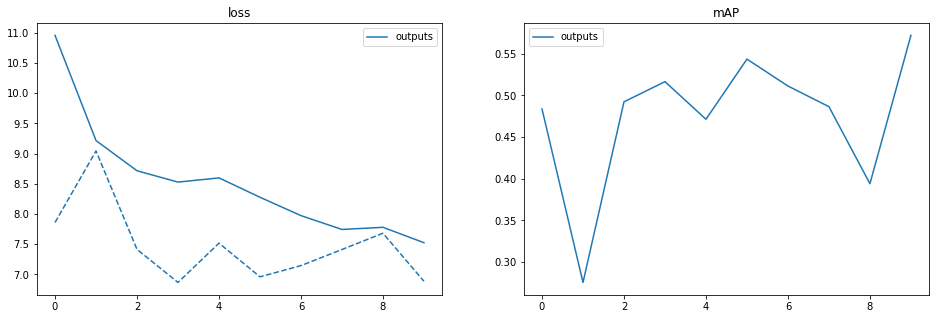

In [20]:
fields_of_interest = (
    'loss',
    'mAP',
    )

plot_logs(log_directory,
          fields_of_interest)

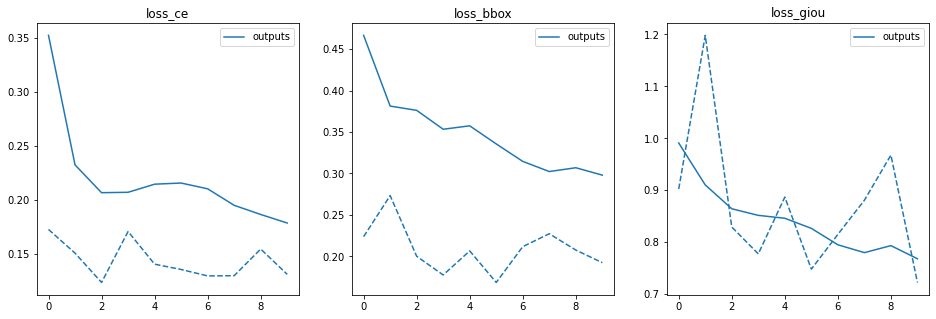

In [21]:
fields_of_interest = (
    'loss_ce',
    'loss_bbox',
    'loss_giou',
    )

plot_logs(log_directory,
          fields_of_interest)

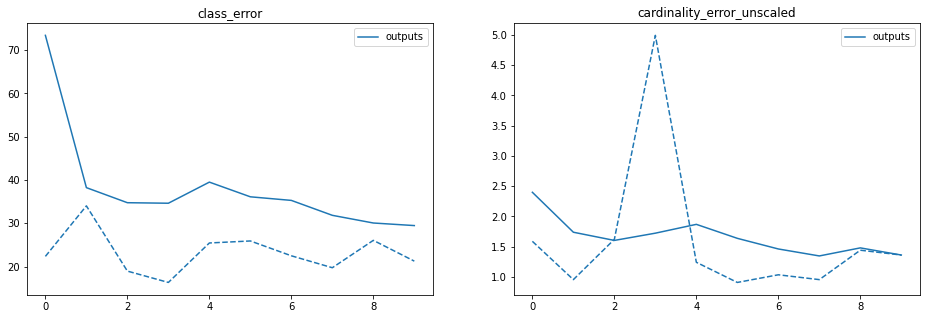

In [22]:
fields_of_interest = (
    'class_error',
    'cardinality_error_unscaled',
    )

plot_logs(log_directory,
          fields_of_interest)

## Loading fine-tuned model

In [23]:
model = torch.hub.load('facebookresearch/detr',
                       'detr_resnet50',
                       pretrained=False,
                       num_classes=num_classes)

checkpoint = torch.load('outputs/checkpoint.pth',
                        map_location='cpu')

model.load_state_dict(checkpoint['model'],
                      strict=False)

model.eval();

Downloading: "https://github.com/facebookresearch/detr/zipball/main" to /tmp/xdg-cache/torch/hub/main.zip
/opt/conda/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [24]:
def plot_finetuned_results(pil_img, prob=None, boxes=None):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    if prob is not None and boxes is not None:
      for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
          ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=c, linewidth=3))
          cl = p.argmax()
          text = f'{finetuned_classes[cl]}: {p[cl]:0.2f}'
          ax.text(xmin, ymin, text, fontsize=15,
                  bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [25]:
def run_worflow(my_image, my_model):
      # mean-std normalize the input image (batch-size: 1)
  img = transform(my_image).unsqueeze(0)

  # propagate through the model
  outputs = my_model(img)

  for threshold in [0.9, 0.8, 0.7]:

    probas_to_keep, bboxes_scaled = filter_bboxes_from_outputs(outputs,
                                                              threshold=threshold)

    plot_finetuned_results(my_image,
                           probas_to_keep,
                           bboxes_scaled)


### With a training image

In [26]:
from PIL import Image

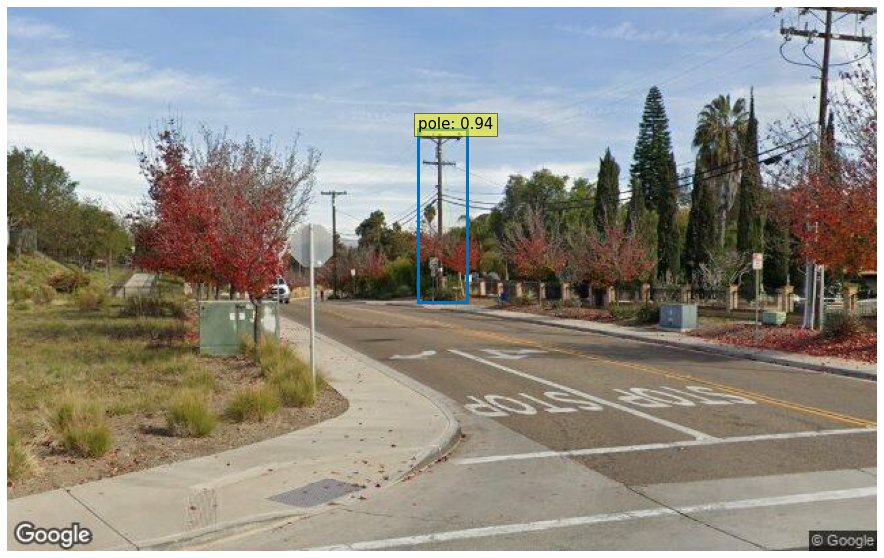

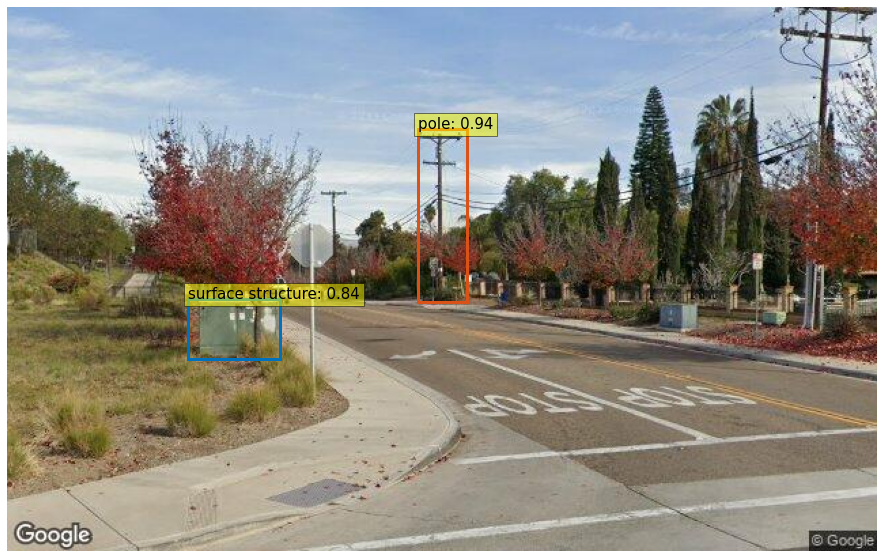

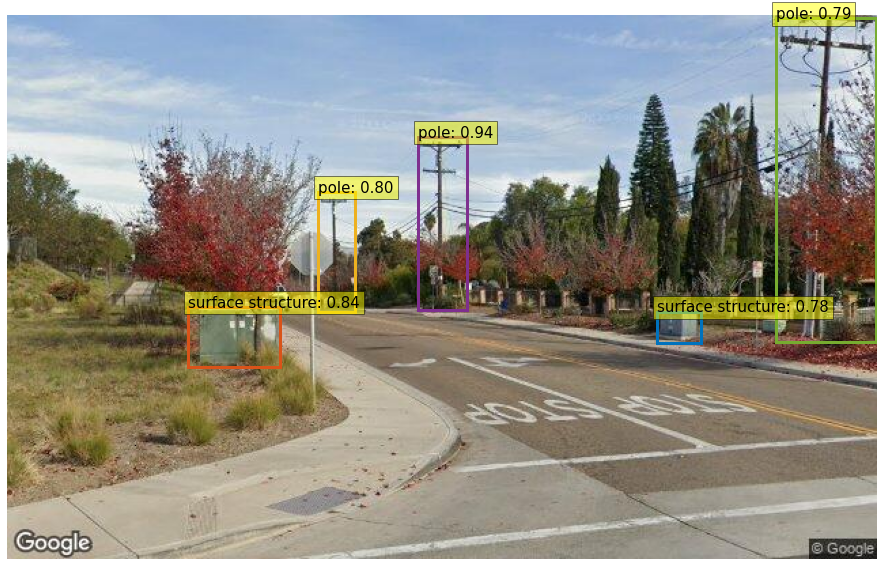

In [27]:
img_name = 'data/custom/train2017/kevin_images_D158798_1_2.jpg'
im = Image.open(img_name)

run_worflow(im,
            model)

### With a validation image

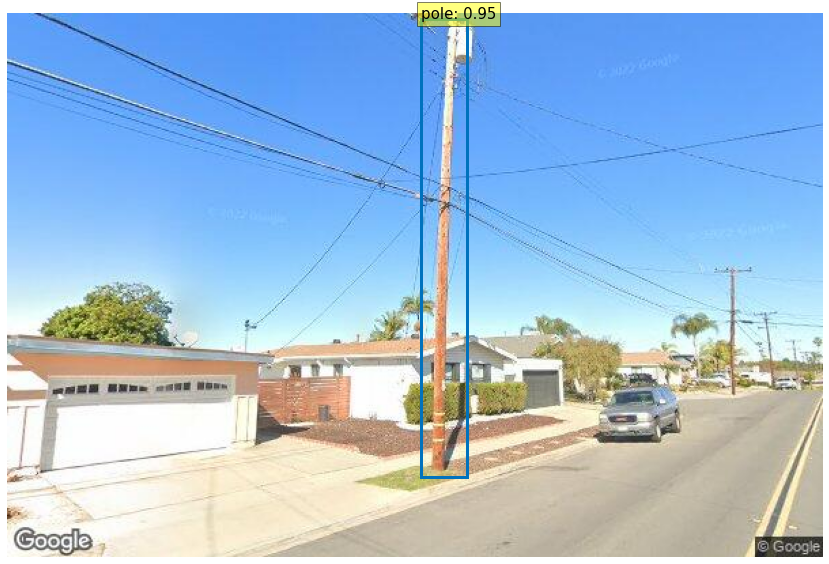

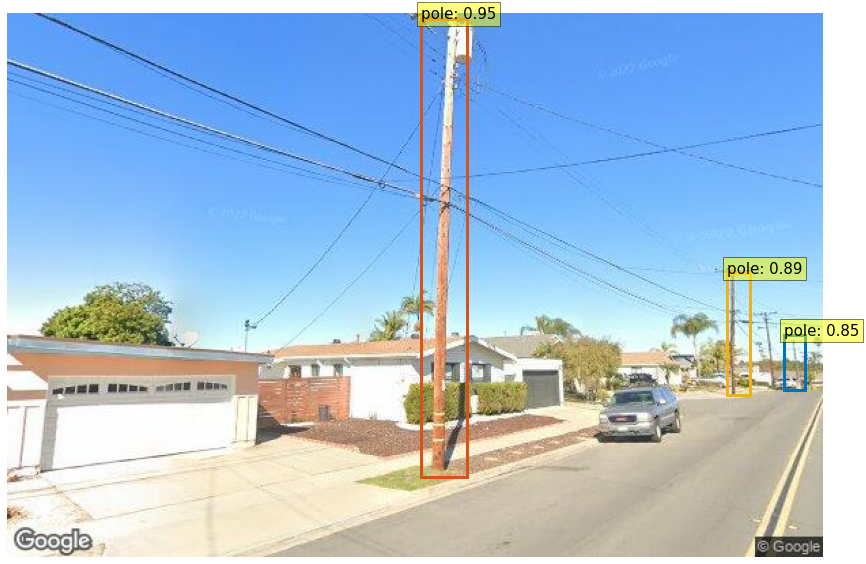

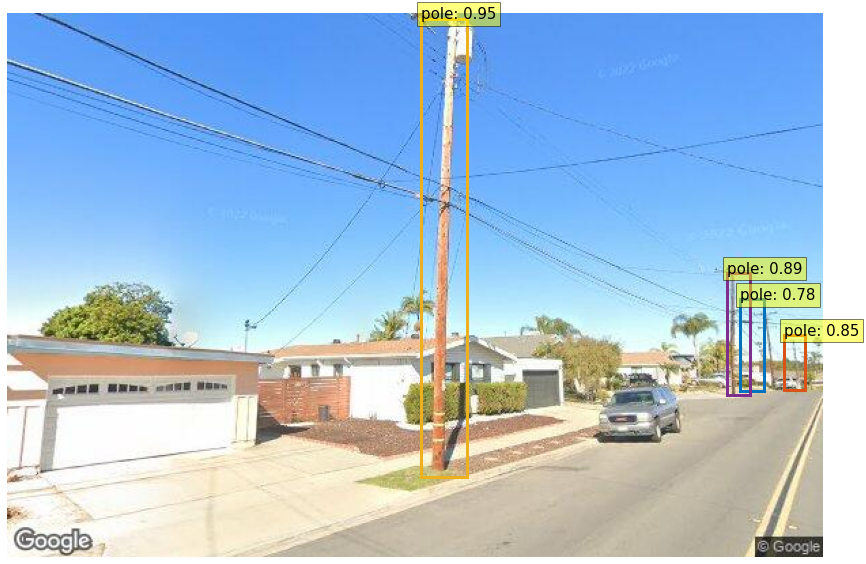

In [28]:
img_name = 'data/custom/val2017/OH4_angle2_fov2.jpg'
im = Image.open(img_name)

run_worflow(im,
            model)